In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

from data.data_reading import data_reading
from data.data_processing import data_processing

from ruspy.simulation.simulation import simulate
from ruspy.simulation.value_zero import calc_ev_0, discount_utility
from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import (
    lin_cost,
    cost_func,
    create_transition_matrix,
    calc_fixp,
    choice_prob
)
from scripts.worst_case_probs import calc_fixp_worst
import pickle as pkl
import glob

In [13]:
# Beta is set almost to one, as the agents objective is to maximize average cost.
beta = 0.9999
# 200 buses should be enough to gurantee convergence.
num_buses = 150
# Set the number of simulated periods to 80000. The first plot shows the convergence at this point.
num_periods = 70000

# Paramters for plotting
gridsize = 1000
num_points = int(num_periods/gridsize)

In [3]:
worst_evs = []
worst_trans_mats = []
for file in sorted(glob.glob("cg_results/*.pkl"))[::5]:
    worst_evs += [pkl.load(open(file, "rb"))[0]]
    worst_trans_mats += [pkl.load(open(file, "rb"))[1]]

In [4]:
trans_mat_ml = worst_trans_mats[0]
ev_ml = worst_evs[0]
ev_worst = worst_evs[-1]

In [5]:
num_states = ev_ml.shape[0]
params = np.loadtxt("scripts/resources/rust_cost_params.txt")
p_ml = np.loadtxt("scripts/resources/rust_trans_probs.txt")
costs = cost_func(num_states, lin_cost, params)

In [6]:
choice_ml = choice_prob(ev_ml, costs, beta)

In [7]:
choice_worst = choice_prob(ev_worst, costs, beta)

[]

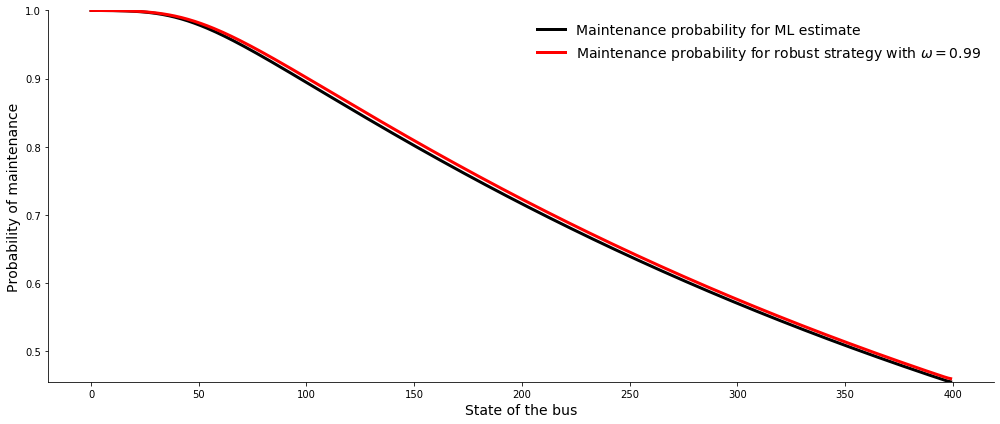

In [8]:
state_range = 400
y_0 = choice_ml[-1, 0]
y_1 = 1

states = range(state_range)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([y_0, y_1])
ax.set_ylabel(r"Probability of maintenance",fontsize=14)
ax.set_xlabel(r"State of the bus", fontsize=14)
ax.plot(states, choice_ml[:state_range, 0], color='k', label='Maintenance probability for ML estimate')
ax.plot(states, choice_worst[:state_range, 0], color='red', label='Maintenance probability for robust strategy with $\omega = 0.99$')


plt.legend()
ax.legend(fontsize=14)
plt.tight_layout()

plt.plot()

In [9]:
var_evs_dfs = []
for file in sorted(glob.glob("scripts/dfs/*.pkl")):
    var_evs_dfs += [pkl.load(open(file, "rb"))]

In [10]:
df_ml = var_evs_dfs[0]
df_worst = var_evs_dfs[-1]

In [14]:
# Calculate the expected value at time zero
v_exp_ml = np.full(num_points + 1, calc_ev_0(df_ml, ev_ml))
v_exp_worst = np.full(num_points + 1, calc_ev_0(df_ml, ev_worst))
# Calculate the value at time 0 by discounting the utility
v_disc_fig_1 = discount_utility(df_worst, gridsize, beta)
# Create a numpy array of the periods for plotting
periods = np.arange(0, num_periods + gridsize, gridsize)

[]

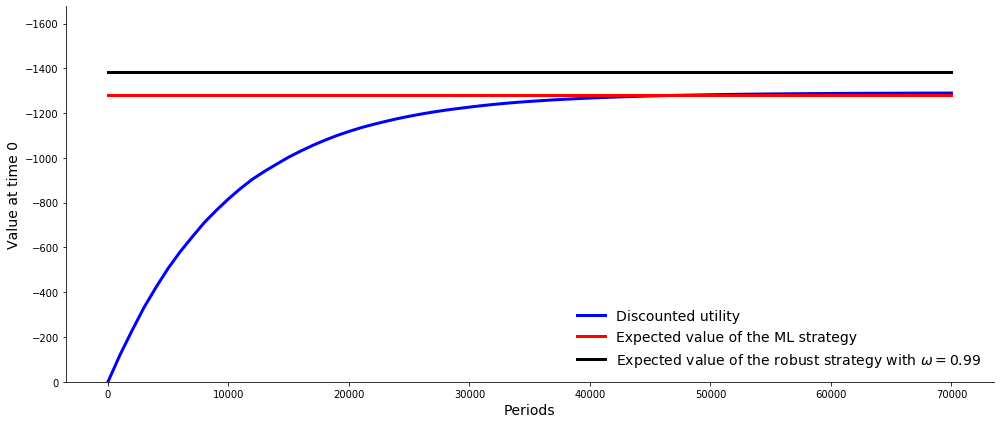

In [15]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0, 1.3 * v_disc_fig_1[-1]])
ax.set_ylabel(r"Value at time 0",fontsize=14)
ax.set_xlabel(r"Periods", fontsize=14)
ax.plot(periods, v_disc_fig_1, color='blue', label='Discounted utility')
ax.plot(periods, v_exp_ml, color='red', label='Expected value of the ML strategy')
ax.plot(periods, v_exp_worst, color='k', label='Expected value of the robust strategy with $\omega = 0.99$')



plt.legend()
ax.legend(fontsize=14)
plt.tight_layout()

plt.plot()

In [16]:
means_robust_strat = np.array([])
for df in var_evs_dfs:
    means_robust_strat = np.append(means_robust_strat, np.mean(df[df["decision"] == 1]["state"]))
means_discrete = np.around(means_robust_strat)

In [26]:
num_omegas = len(var_evs_dfs)
omega_range = np.linspace(0, 0.60606, num_omegas)
means_ml = np.full(num_omegas, np.around(means_robust_strat[0]))

In [64]:
omega_sections = []
state_sections = []
for j, i in enumerate(np.unique(means_discrete)):
    where = means_discrete == i
    if j == 0:
        med_val = (np.max(omega_range[where]) + np.min(omega_range[~where])) / 2
        omega_sections += [np.append(omega_range[where], med_val)]
        state_sections += [np.append(means_discrete[where], i)]
    elif j > 0:
        med_val_low = (np.min(omega_range[where]) + np.max(omega_sections[-1])) / 2
#         med_val_high = (np.max(omega_range[where]) + np.max(omega_sections[-1])) / 2
        omega_sections += [np.append(med_val, omega_range[where])]
        state_sections += [np.append(i, means_discrete[where])]

In [65]:
omega_sections, state_sections

([array([0.       , 0.050505 , 0.10101  , 0.1262625]),
  array([0.1262625, 0.151515 , 0.20202  , 0.252525 , 0.30303  , 0.353535 ,
         0.40404  , 0.454545 ]),
  array([0.1262625, 0.50505  , 0.555555 , 0.60606  ])],
 [array([57., 57., 57., 57.]),
  array([58., 58., 58., 58., 58., 58., 58., 58.]),
  array([59., 59., 59., 59.])])

[]

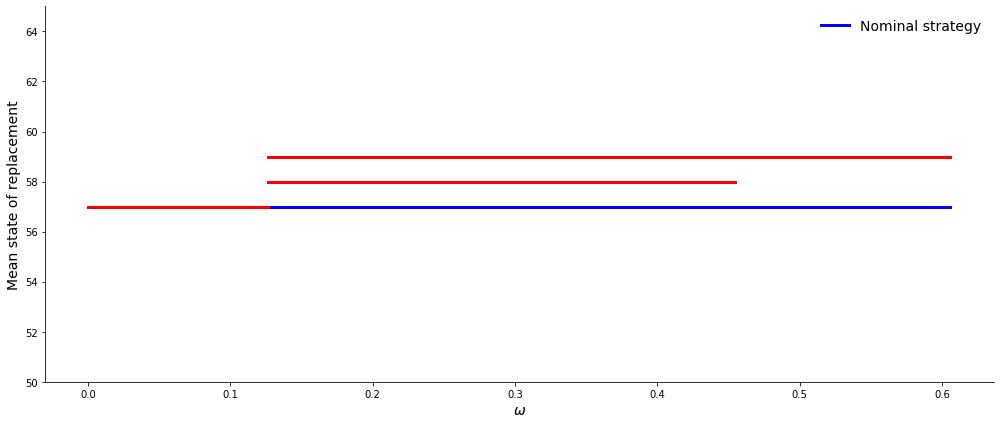

In [66]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([50, 65])
ax.set_ylabel(r"Mean state of replacement",fontsize=14)
ax.set_xlabel(r"$\omega$", fontsize=14)
ax.plot(omega_range, means_ml, color='blue', label='Nominal strategy')
for j, i in enumerate(omega_sections):
    ax.plot(i, state_sections[j], color='red')



plt.legend()
ax.legend(fontsize=14)
plt.tight_layout()

plt.plot()